# In Game Toxicity seq2seq classification
A2 

# Load data

In [ ]:
train_data = pd.read_csv("/content/train.csv")
val_data = pd.read_csv("/content/validation.csv")
test_data = pd.read_csv("/content/test_without_labels.csv")

In [ ]:
# convert to list
X_train_raw = train_data['sents'].tolist()
y_train_raw = train_data['labels'].tolist()
X_val_raw = val_data['sents'].tolist()
y_val_raw = val_data['labels'].tolist()
X_test_raw = test_data['sents'].tolist()

In [ ]:
print("------------------------------------")
print("Size of training dataset: {0}".format(len(train_data)))
print("Size of testing dataset: {0}".format(len(test_data)))
print("------------------------------------")
sample_ix = 17
print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(y_train_raw[sample_ix], X_train_raw[sample_ix]))
print("------------------------------------")

------------------------------------
Size of training dataset: 26078
Size of testing dataset: 500
------------------------------------
------------------------------------
Sample Data
LABEL: O O SEPA P O O O / SENTENCE: just end [SEPA] i wan nex game
------------------------------------


In [ ]:
train_data.head(3)
# 5	i cant [SEPA] play [SEPA] with 4 trash   |	P O SEPA O SEPA O O O

,sents,labels
0,wow,O
1,WTF,T
2,wpe wpe,O O


In [ ]:
# Tokenise words
X_train = Prep.tokenise_words(X_train_raw)
X_val = Prep.tokenise_words(X_val_raw)
X_test = Prep.tokenise_words(X_test_raw)

In [ ]:
# tokenise tags
y_train = Prep.tokenise_tags(y_train_raw)
y_val = Prep.tokenise_tags(y_val_raw)

In [ ]:
print(X_train[17])
print(y_train[17])

['just', 'end', '[sepa]', 'i', 'wan', 'nex', 'game']
['O', 'O', 'SEPA', 'P', 'O', 'O', 'O']


word_to_ix

In [ ]:
word_to_ix, word_list = Prep.get_word_to_ix(X_train+X_val+X_test)
tag_to_ix = Prep.get_tag_to_ix(y_train + y_val)
ix_to_tag = {y: x for x, y in tag_to_ix.items()}

In [ ]:
X_train_len = [len(x) for x in X_train]
X_val_len = [len(x) for x in X_val]
X_test_len = [len(x) for x in X_test]

max_seq_length = max(X_train_len + X_val_len + X_test_len)
X_train_attn_pad = [[True]*len(x)+[False]*(max_seq_length - len(x)) for x in X_train]
X_val_attn_pad = [[True]*len(x)+[False]*(max_seq_length - len(x)) for x in X_val]
X_test_attn_pad = [[True]*len(x)+[False]*(max_seq_length - len(x)) for x in X_test]

encode

In [ ]:
# Convert input to idx, vectoriser
X_train_index =  Prep.encode_to_index_and_pad(X_train,word_to_ix) # (26078, 57)
y_train_index = Prep.encode_to_index_and_pad(y_train,tag_to_ix)
X_val_index = Prep.encode_to_index_and_pad(X_val, word_to_ix)
y_val_index = Prep.encode_to_index_and_pad(y_val,tag_to_ix)
X_test_index = Prep.encode_to_index_and_pad(X_test,word_to_ix)

embed

In [ ]:
dota_data, toxic_data = Emb.get_domain_dataset()
dota_embed = Emb.make_self_trained_gensim_model(dota_data, dimension_=50, window_=3) 
toxic_embed = Emb.make_self_trained_gensim_model(toxic_data, dimension_=50, window_=3) 

In [ ]:
fasttext_embed = Emb.make_self_trained_gensim_model(X_train+X_val+X_test, dimension_=50, window_=3) 
glove_twitter_gensim = api.load("glove-twitter-25") 

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
# get additional embedding
# load features from file to save time
pos_features=np.load('/content/features/pos_features.npy', allow_pickle=True).tolist()
dep_features=np.load('/content/features/dep_features.npy', allow_pickle=True).tolist()

# 💎 uncomment below to run the code
# 3mins
# features = Emb.get_word_features(X_train_raw+X_val_raw+X_test_raw)
# pos_features, dep_features = features['pos'], features['dep']

In [ ]:
f = Emb.get_word_features(X_train_raw+X_val_raw+X_test_raw) # 
len_features, cap_features = f['len'], f['cap']

In [ ]:
pretrained_index = 25 # first n cols
all_embeds = [
    glove_twitter_gensim,
    fasttext_embed, 
    len_features,
    cap_features,
    pos_features,
    dep_features,
    dota_embed,
    toxic_embed
]
all_embeds_name = [
    'glove_twitter_gensim',
    'fasttext_embed', 
    'len_features',
    'cap_features',
    'pos_features',
    'dep_features',
    'dota_embed',
    'toxic_embed'
]

In [ ]:
embed_matrix, embed_matrix_dim = Emb.build_concat_embed_table(word_list, all_embeds)

In [ ]:
# # sanity check
# X_train_index = X_train_index[:100]
# y_train_index = y_train_index[:100]
# X_val_index = X_val_index[:100]
# y_val_index = y_val_index[:100]

# batch train

In [ ]:
def to_torch(x):
    return torch.from_numpy(np.array(x)).to(device)
    

N_EPOCH = 2
BATCH_SIZE = 20
HIDDEN_DIM = 50
VOCAB_SIZE = len(word_to_ix)
N_DIRECTION = 2
################################## dataset ##################################
# train set below
X_train_len_torch = to_torch(X_train_len).cpu() 
X_train_attn_pad_torch = to_torch(X_train_attn_pad).to(device)
X_train_torch = to_torch(X_train_index) 
y_train_torch = to_torch(y_train_index) 
training_set = CustomDataSet(X_train_torch, y_train_torch, X_train_len_torch, X_train_attn_pad_torch)
params_dataset = {'batch_size': BATCH_SIZE,
        'shuffle': True,
        'drop_last':True # if the sample size cannot be batched properly
        }
train_generator = torch.utils.data.DataLoader(training_set, **params_dataset)

# validation set below
X_val_torch = to_torch(X_val_index) 
y_val_torch = to_torch(y_val_index) 
X_val_attn_pad_torch = to_torch(X_val_attn_pad).to(device)
X_val_len_torch = to_torch(X_val_len).cpu() 

val_set = CustomDataSet(X_val_torch, y_val_torch, X_val_len_torch, X_val_attn_pad_torch)
params_dataset = {'batch_size': BATCH_SIZE,
        'shuffle': True,
        'drop_last':True # if the sample size cannot be batched properly
        }
val_generator = torch.utils.data.DataLoader(val_set, **params_dataset)

# Test Program

## funcs

In [ ]:
import datetime
def get_model_args():
    return {
        'vocab_size': VOCAB_SIZE, 
        'n_direction':N_DIRECTION, # bi direction or 1
        'tag_to_ix': tag_to_ix, 
        'embedding_dim': embed_matrix_dim, 
        'embed_matrix':embed_matrix,
        'hidden_dim': HIDDEN_DIM, 
        'batch_size': BATCH_SIZE, 
        'nhead':1,
        'stack_layers':1, # 3, 5 does not learn
        'attn_name': ['location_base', 'scaled_dot_product', 'dot_product', 'additive'], 
        'is_lstm2': False,
        'is_lstm3': False,
        'is_attn1':False,
        'is_attn2':False,
        'is_attn3':False,
        'is_pretrained':False
    }

def train(model_args_, is_report=False, is_print=False):
    model = BiLSTM_attn(model_args_).to(device)
    optimizer = optim.Adam(model.parameters(),  lr=1e-2, weight_decay=1e-4) # 2e-3
    criterion = nn.CrossEntropyLoss()

    ################################## Epoch loss history ##################################
    report = ()
    for epoch in range(N_EPOCH):  
        time1 = datetime.datetime.now()

        train_loss = []

        for local_batch, local_labels, local_lens, local_pad in train_generator:
            model.train()
            model.zero_grad()

            y_pred = model(local_batch, local_lens, local_pad)#, local_pad)
            
            batch_size, seq_len = local_batch.size()
            # torch.Size([1440, 10]) the loss function will make it same as RHS,  torch.Size([1440]), 
            loss = criterion(y_pred.view(batch_size * seq_len, -1), local_labels.view(batch_size * seq_len))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) # https://www.reddit.com/r/MachineLearning/comments/kqgne3/choosing_gradient_norm_clip_value_d/
            optimizer.step()
            
            train_loss.append(loss.item())
        # since batch, so avg
        train_loss = np.mean(train_loss)

        model.eval()
        # evaluation
        with torch.no_grad():
            train_f1, _ = eval_f1(model, train_generator)
            val_f1, val_report = eval_f1(model, val_generator, is_report)

            time2 = datetime.datetime.now()

            print("Epoch:%d, Training loss: %.2f, time: %.2fs" %(epoch+1, train_loss, (time2-time1).total_seconds()))
            print('train_f1', train_f1, 'val_f1', val_f1)
            if is_report and epoch+1 == N_EPOCH:
                report = (val_f1, val_report)
            if is_print:
                print(val_report)
    if is_print:
        return
    if is_report:
        return report

In [ ]:
def test_performance():
    print("💎 1 Performace Comparison 💎")
    model_args = get_model_args()
    f1, report = train(model_args, True)
    p('')  
    print('T-F1: ', f1)
    
    for k, v in report.items():
        try:
            i = int(k)
        except:
            continue
        if i not in [0,1]: # ignore pad and SEPA
            print(f'T-F1({ix_to_tag[i]}): ', v['f1-score'])

    p('')   

In [ ]:
def test_embedding():
    base_ix = 1 # self train on given dataset
    print("💎 2 Embedding 💎")
    print("Name: ", all_embeds_name[base_ix])
    model_args = get_model_args()
    embed_matrix_, embed_matrix_dim_ = Emb.build_concat_embed_table(word_list, [all_embeds[base_ix]])
    model_args['embed_matrix'] = embed_matrix_
    model_args['embedding_dim'] = embed_matrix_dim_
    
    train(model_args)
    p('')    
    print('💎 Below is feature addition to the existing self-train embedding')
    p('')
    for i in range(0, len(all_embeds_name)):
        if i == base_ix: # ignore baseline embedding
            continue
        print("Name: ", all_embeds_name[i])
        model_args = get_model_args()
        embed_matrix_, embed_matrix_dim_ = Emb.build_concat_embed_table(word_list, [all_embeds[base_ix], all_embeds[i]])
        model_args['embed_matrix'] = embed_matrix_
        model_args['embedding_dim'] = embed_matrix_dim_
        if i == 0:
            model_args['is_pretrained'] = True
        train(model_args)
        p('')    

In [ ]:
def test_attn_func():
    print("💎 3 Attention 💎")
    for i in range(4):
        model_args = get_model_args()
        model_args['attn_name'] = model_args['attn_name'][i]
        model_args['is_attn1'] = True
        print("Types: ", model_args['attn_name'])
        train(model_args)
        p('')    

In [ ]:
def test_attn_position():
    print("💎 3 Attention - Position 💎")
    p('')
    model_args = get_model_args()
    attn_name_ = model_args['attn_name'][1]
    model_args = get_model_args()
    model_args['attn_name'] = attn_name_
    print('After the first layer')
    model_args['is_attn1'] = True
    train(model_args)
    p('')    
    print('After the second layer')
    model_args = get_model_args()
    model_args['attn_name'] = attn_name_
    model_args['is_attn2'] = True
    model_args['is_lstm2'] = True
    train(model_args)
    p('')    
    print('After the third layer')
    model_args = get_model_args()
    model_args['attn_name'] = attn_name_
    model_args['is_attn3'] = True
    model_args['is_lstm2'] = True
    model_args['is_lstm3'] = True
    train(model_args)
    p('')  


In [ ]:
def test_stack_seq2seq():
    print("💎 4 Stacked Seq2Seq model 💎")
    for i in range(1, 5):
        print("Number of Stack layers: ", i)
        model_args = get_model_args()
        model_args['stack_layers'] = i
        train(model_args)
        p('')   

In [ ]:
def test_crf():
    print("💎 5 with CRF 💎")
    pipeline(X_train, y_train, word_to_ix, tag_to_ix)
    print("💎 5 without CRF 💎")
    model_args = get_model_args()
    train(model_args, is_print=True)

## run all 

In [ ]:
test_performance()

test_embedding()

test_attn_func()
test_attn_position()

test_stack_seq2seq()

test_crf()

💎 1 Performace Comparison 💎
Epoch:1, Training loss: 0.18, time: 16.68s
train_f1 0.937883411942415 val_f1 0.935654106101287
Epoch:2, Training loss: 0.01, time: 16.28s
train_f1 0.9435033478354778 val_f1 0.9372970967442723

T-F1:  0.9372970967442723
T-F1(O):  0.9850870355936607
T-F1(T):  0.9267767408470926
T-F1(P):  0.9915579432079816
T-F1(S):  0.9818070631401926
T-F1(D):  0.7336523125996811
T-F1(C):  0.9471686175260993

💎 2 Embedding 💎
Name:  fasttext_embed
Epoch:1, Training loss: 0.20, time: 16.48s
train_f1 0.9203373077160685 val_f1 0.9177420852288553
Epoch:2, Training loss: 0.01, time: 16.38s
train_f1 0.9242503621066905 val_f1 0.922165664044424

💎 Below is feature addition to the existing self-train embedding

Name:  glove_twitter_gensim
Epoch:1, Training loss: 0.18, time: 16.57s
train_f1 0.940317852183305 val_f1 0.9386429035551842
Epoch:2, Training loss: 0.01, time: 16.70s
train_f1 0.9398419655534292 val_f1 0.9364843532361408

Name:  len_features
Epoch:1, Training loss: 0.18, time: 16

## additional tests

- Note: Typing mistake. The log text should print 3 embeddings.

In [ ]:
# additional embed tests

def test_embedding_additional(idx_1, idx_2):
    base_ix = 1 # self train on given dataset
    print("💎 2 Embedding 💎")
    print("Name: ", all_embeds_name[base_ix], '+', all_embeds_name[idx_1], '+', all_embeds_name[idx_2])
    model_args = get_model_args()
    embed_matrix_, embed_matrix_dim_ = Emb.build_concat_embed_table(word_list, [all_embeds[base_ix], all_embeds[idx_1], all_embeds[idx_2]])
    model_args['embed_matrix'] = embed_matrix_
    model_args['embedding_dim'] = embed_matrix_dim_
    
    train(model_args)
    p('')    

test_embedding_additional(3, 4)
test_embedding_additional(3, 6)
test_embedding_additional(4, 6)



💎 2 Embedding 💎
Name:  fasttext_embed + cap_features + pos_features
Epoch:1, Training loss: 0.20, time: 15.56s
train_f1 0.9150228085316238 val_f1 0.9110781771026306
Epoch:2, Training loss: 0.01, time: 15.52s
train_f1 0.9468259111810635 val_f1 0.9392562366688305

💎 2 Embedding 💎
Name:  fasttext_embed + cap_features + dota_embed
Epoch:1, Training loss: 0.20, time: 15.53s
train_f1 0.9397226502311248 val_f1 0.9368567454798331
Epoch:2, Training loss: 0.01, time: 15.65s
train_f1 0.9527894347074797 val_f1 0.9474953617810761

💎 2 Embedding 💎
Name:  fasttext_embed + pos_features + dota_embed
Epoch:1, Training loss: 0.18, time: 15.93s
train_f1 0.9163533255254885 val_f1 0.9136111111111112
Epoch:2, Training loss: 0.01, time: 15.65s
train_f1 0.9387144531490963 val_f1 0.9341995359628771



Note that the CRF result is incorrect on the first big code cell since the environments are different for the model, below is the correct version:
CRF attachment

In [ ]:
def test_crf_v2():
    print("💎 5 with CRF 💎")
    pipeline(X_train, y_train, word_to_ix, tag_to_ix)
    print("💎 5 without CRF 💎")
    model_args = get_model_args()
    train(model_args, is_print=True)
test_crf_v2()

💎 5 with CRF 💎
Epoch:1, Training loss: 26921.06, time: 520.24s
train_f1 0.9726499938400887 val_f1 0.9655140532544378
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3603
           2       0.99      1.00      0.99     18985
           3       0.98      0.94      0.96      1469
           4       1.00      1.00      1.00      3936
           5       1.00      0.99      0.99      3322
           6       0.96      0.70      0.81       398
           7       0.95      0.96      0.96      1641

    accuracy                           0.99     33354
   macro avg       0.98      0.94      0.96     33354
weighted avg       0.99      0.99      0.99     33354

Epoch:2, Training loss: 2782.26, time: 514.06s
train_f1 0.9944754791518781 val_f1 0.9800461893764434
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3603
           2       0.99      1.00      1.00     18985
           3       0.9

# OOP

## Set up file

### Import

In [ ]:
############################################ general ###########################################
import shutil # move files
import os
from typing import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import string

import time
import math
import random

############################################ data manipulation ############################################
import pandas as pd
import numpy as np

############################################ pretrain  ############################################
# TODO: Glove 
from gensim.models import Word2Vec 
from gensim.models import FastText
import gensim.downloader as api

############################################ preprocessing ############################################
import nltk
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize

import re
############################################ Spacy ############################################
# !pip install -U -q pip setuptools wheel
!pip -q install -U  spacy
!python -q -m spacy download en_core_web_sm  | grep -v 'already satisfied' # en_core_web_trf

import spacy
from spacy.tokenizer import Tokenizer
############################################ pytorch ############################################
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

############################################ sklearn ############################################
from sklearn.metrics import f1_score

############################################ clean up pwd ############################################
!rm -r /content/sample_data # remove default data folder

############################################ set seed ############################################

CONFIG = {
    'seed': 23
}

def set_seed(seed=42):
    '''Sets seed so result unchanged - reproducibility'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

     |████████████████████████████████| 6.2 MB 24.0 MB/s 
     |████████████████████████████████| 10.1 MB 61.8 MB/s 
     |████████████████████████████████| 181 kB 73.8 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 457 kB 62.2 MB/s 
     |████████████████████████████████| 660 kB 70.3 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installa

### Google drive connection

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
# Authenticate
gdrive = None
def authenticate():
    global gdrive
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    gdrive = GoogleDrive(gauth)

#Download files
def downloadFiles(fileIds):
    authenticate()
    for fileId in fileIds:    
        downloaded = gdrive.CreateFile({"id": fileId[1]})
        downloaded.GetContentFile(fileId[0])

## Helper file

In [ ]:
class Helper:
    
    def __init__(self):
        self.pwd = '/content'
        self.jigsaw_path = f'{self.pwd}/jigsaw'
        self.featuers_path = f'{self.pwd}/features'
        self.dota_path = f'{self.pwd}/dota'

        # Supply dataset
        self.gdrive_supply_files = {
            'train_csv': ('train.csv', '1WBFZINdPeGN_86Mm_yyAEqDnZMCGdBP0'),
            'val_csv': ('validation.csv', '1jCazOeqrgw2kghMoRdT6SPEQc7ZEkryj'),
            'test_csv': ('test_without_labels.csv', '1mAhSjNNBALEY9c5yk70eA8SEo6lkeHrF'),
            'sample_csv': ('sample.csv', '1WPCOgJDfggM58SXbLRJV9v3EMunzRBDX')
        }
        
        # Jigsaw comment - https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview
        self.gdrive_jigsaw = {
            'jigsaw_train': ('jigsaw_train.csv', '1EM3s2ptPtJ6c_N5yT_NphzR8qXUy3ep0'),
            'jigsaw_train_zip': ('train.csv.zip', '1Y9bSMSAx2Tvi64rLoKnecVWd4zOhzSQW')
        }
        # Dota 2 Wiki dataset
        self.gdrive_dota = {
            'dota_wiki': ('dota_wiki.txt', '18Md9xdJLVhIpSvm1Ws9J6Tb605ka24Rr')
        }
        self.gdrive_features = {
            'pos_feaures': ('pos_features.npy', '187oMCdy7uOW9-orsk20MWw3pskYp1XXm'),
            'dep_feaures': ('dep_features.npy', '1oG-XlC_N7lbkvHM6EvsMN57iffwoPRvg')
        }
        self.data = [self.gdrive_supply_files, self.gdrive_jigsaw, self.gdrive_features, self.gdrive_dota]


        # Load all gdrive files
        self.load_all_gdrive_files()

        # move and organises folder
        self.move_files_in_folder(self.gdrive_jigsaw, self.jigsaw_path)
        self.move_files_in_folder(self.gdrive_features, self.featuers_path)
        self.move_files_in_folder(self.gdrive_dota, self.dota_path)

    def load_all_gdrive_files(self):
        # 1: Collect 
        file_dict = {}
        for d in self.data:
            file_dict.update(d)
        
        # 2: Load every needed csv files into current pwd
        for _, file in file_dict.items():
            fname, f_link = file
            self.load_one_gdrive_file(fname, f_link)
                                   
    def load_one_gdrive_file(self, fname:str, gdrive_link:str):
        """Download file if not existing"""
        try:
            _ = open(fname, "r")
        except:
            downloadFiles([[fname, gdrive_link]])
            _ = open(fname, "r")

    def move_files_in_folder(self, folder_dict:dict, folder_name:str):
        """Move files from pwd to a dedicated folder"""
        
        if not os.path.exists(folder_name):
                os.makedirs(folder_name)

        for _ , f in folder_dict.items():
            fname, _ = f
            shutil.move(f"{self.pwd}/{fname}", f"{folder_name}/{fname}")
    # Note: Due to time contraints, this is the third worst code design I ever coded.
    """
    from google.colab import files
    files.download('pos_features.npy') 
    """
Myhelper = Helper()

In [ ]:
def p(x):
    print(x)
def dbg(x):
    print("#################################### ", x, " ####################################")

## Preprocessing file

In [ ]:
class Preprocessing:
    def __init__(self) -> None:
        # self.BOS = "<BOS>"
        # self.EOS = "<EOS>"
        self.PAD = "<PAD>"
        self.SEPA = "SEPA"
        self.ix_to_tag = None

    ########################### 1 word tokenisation ###########################
    def tokenise_words(self, sent_list):
        output = []
        for sent in sent_list:
            # lowercase
            sent = sent.lower()
            output.append(sent.split())
        return output

    def tokenise_only(self, sent_list):
        output = []
        for sent in sent_list:
            output.append(sent.split())
        return output

    def tokenise_tags(self, tag_list):
        output = []
        for tag in tag_list:
            output.append(tag.split())
        return output
    
    ########################### encode str to index ###########################

    def get_word_to_ix(self, Xs):
        """set up a vocab to index dictionary"""

        word_to_ix = {self.PAD:0}
        assert type(Xs) == list, 'X_train + X_val + X_test'

        for sentence in Xs:
            for word in sentence:
                word = word.lower()
                if word not in word_to_ix:
                    word_to_ix[word] = len(word_to_ix)
        word_list = list(word_to_ix.keys())
        return word_to_ix, word_list
        
    def get_tag_to_ix(self, ys):
        assert type(ys) == list, 'y_train + y_val'

        tag_to_ix = {self.PAD:0, self.SEPA:1} # all unique
        for tags in ys:
            for tag in tags:
                if tag not in tag_to_ix:
                    tag_to_ix[tag] = len(tag_to_ix)
        self.ix_to_tag = {y: x for x, y in tag_to_ix.items()}
        return tag_to_ix

    def get_ix_to_tag(self):
        return self.ix_to_tag

    def encode_to_index_and_pad(self, sent_tokenised_list, dictionary, max_len=72):
        """ construct token index lists for input, output and target """
        res = []
        # TODO: decide whether to use tge largest or manully set one
        
        for sent in sent_tokenised_list:
            encoded = [dictionary[t] for t in sent]
            if len(encoded) < max_len:
                encoded += [dictionary[self.PAD]] * (max_len - len(encoded)) 
            if len(encoded) > max_len:
                encoded = encoded[:max_len]
            res.append(encoded)
        return res
    def encode_to_index(self, token_list, dictionary):
        """ construct token index lists for input, output and target """
        res = []
        for tok in token_list:
            res.append([dictionary[t] for t in tok])
        return res
    # def v2(self, sent_list):
    #     output = []
    #     for sent in sent_list:
    #         sent = sent.lower()
    #         for word, new_word in contraction_dict.items():
    #             sent = sent.replace(word, new_word)
    #         sent = re.sub(r'[^\w\s]','',sent)        
    #         output.append(word_tokenize(sent))
    #     return output

Prep = Preprocessing()

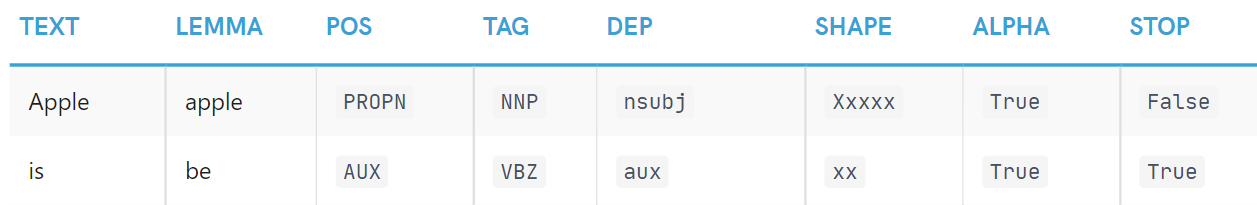

### tokenisation demo

In [ ]:
# Based on below, we should not use word_token()
tmp = 'i cant [SEPA] play [SEPA] with 4 trash'
tmp = '; P ; BD'
tmp = "the comeback    is real :)"
p( word_tokenize(tmp) ) 
p ( tmp.split() ) 

['the', 'comeback', 'is', 'real', ':', ')']
['the', 'comeback', 'is', 'real', ':)']


In [ ]:
# TODO: convert abbreviation to normal form
"""just end [SEPA] i wan nex game"""

'just end [SEPA] i wan nex game'

## Embedding 

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=["lemmatizer"])  # en_core_web_trf
# tokenise based on whitespaces only
nlp.tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r'\S+').match)

In [ ]:
class Embedding():
    def __init__(self):
        # the accuracy one not the efficiency: https://spacy.io/usage
        self.spacy_model = nlp
        self.pos_list = ["ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X", "SPACE"]
        self.dep_list = self.spacy_model.get_pipe("parser").labels

    ########################### Feature embedding ###########################
    def _np(self, f):
        """convert to numpy features"""
        return np.array([f])

    def get_dep_and_pos(self, text):
        """use spacy API to get POS tag and dependency path
        return: list of predicted tags for each token
        """
        # split by spaces only
        
        dep = []
        pos = []
        tokenised = self.spacy_model(text)
        for tok in tokenised:
            dep.append(tok.dep_) # dep_ gives the actual name while this gives the hash value
            pos.append(tok.pos_)
        return dep, pos

    # def one_hot_encoding(self, label_list, actual_list):
    #     """one hot encoding for tags and dependency path
    #     For example:
    #     actual_list: ['Tom'] has actual_list=['NN']
    #     label_list: ['NN', and other taggers]
    #     """
    #     res = [0] * len(label_list)
    #     for el in actual_list:
    #         ix = label_list.index(el)
    #         res[ix] = 1
    #     return np.array(res)

    def get_predicted_word_features(self, raw_data):
        """return the pos and depdency path feature for each seq"""
        res = {
            'pos':{}, # detail pos
            'dep':{}
        }
 
        for seq in raw_data:
            
            dep, pos = self.get_dep_and_pos(seq)
            
            # below are operations for each word
            s = seq.split()
            
            for i in range(len(s)):
                word = s[i]
                w = word.lower()
                
                if w not in res['pos'].keys():
                    res['pos'][w] = [] 
                    res['dep'][w] = [] 
                    
                res['pos'][w].append(self.pos_list.index(pos[i])) 
                res['dep'][w].append(self.dep_list.index(dep[i])) 
 
        # choose the most votes tag
        for k, v in res['pos'].items():
            res['pos'][k] = self._np(max(set(v), key=v.count))
        for k, v in res['dep'].items():
            res['dep'][k] = self._np(max(set(v), key=v.count))
        return res

    def get_word_features(self, raw_data):
        """return the len feature for each seq"""
        data_ = Prep.tokenise_only(raw_data)
        res = {
            'len': {},
            'cap':{}, # frequency of being cap
        }

        for seq in data_:
            
            for i in range(len(seq)):
                word = seq[i]
                w = word.lower()
                
                # len
                if w not in res['len'].keys():
                    res['len'][w] = self._np(len(word))
                    res['cap'][w] = [] 
                else:
                    if word.isupper():
                        res['cap'][w].append(1) # old + new freq
                    else:
                        res['cap'][w].append(0)
        # convert cap list to cap prob
        for k, v in res['cap'].items():
            if len(v) != 0:
                res['cap'][k] = self._np(round(sum(v) / len(v), 2))
            else:
                res['cap'][k] = self._np(0)
        return res

    ########################################################################################################################################
    """
    Build training model for word embeddings: You are to build a training model for word embeddings. 
    You are required to articulate the hyperparameters [Lab2] you choose (dimension of embeddings and window size) 
    in Section 4.1. Note that any word embeddings model [Lab2] (e.g. word2vec-CBOW, word2vec-Skip gram, fasttext, glove) 
    can be applied. (Section 4.1. and Section 4.3., Justify your decision)
    """
    def make_self_trained_gensim_model(self, posts_, dimension_=25, window_=3, which_=1) -> Type[Word2Vec]:
        """contruct gensim word2vec model
        Args:
            posts_(List[str]): a list of string: either F - Feeler or T - Thinker
        Returns:
            (gensim.model.Word2Vec): gensim API to create word2vec model
        """
        #TODO: params
        models = {
            1: FastText, # OOV
            2: Word2Vec
        }
        return models[which_](sentences=posts_, size=dimension_, window=window_, min_count=5, workers=4, sg=1, seed=42)

    def build_concat_embed_table(self, word_list_: list, embeddings:List[object]) -> np.array:
        """ Build the embedding table from the pre-train model.
        Extract those word embedding that exists in the vocab of the current dataset
        Args:
            word_list_(list): a list of unique word in the corpus
        Returns:
            embeddings(List[gensim.model]): a list of gensim models
        The inner element should be in np array

        a = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        b = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        np.concatenate((a, b), 0)
        output: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        """
        emb_dim = 0
        emb_dim_list = []
        for eb in embeddings:
            # TODO
            if type(eb) == dict:
                emb_dim_list.append(next(iter(eb.values())).shape[0]) # the shape of one element in the dict
            else:
                emb_dim_list.append(eb.vector_size)
        emb_dim = sum(emb_dim_list)

        emb_table = []

        # TODO: handle missing value in embedding
        for word in word_list_:
            concat = []
            for i, eb in enumerate(embeddings):
                
                if word in eb:
                    if concat == []: # not initalised
                        concat = eb[word]
                    else:
                        concat = np.concatenate((concat, eb[word]), 0)
                else:
                    # use 0 to represent missing value instead e.g. [unk]
                    unk = np.array([0]*emb_dim_list[i])
                    if concat == []:
                        concat = unk
                    else:
                        concat = np.concatenate((concat, unk), 0)
            emb_table.append(concat)    

        return np.array(emb_table), emb_dim

    def get_domain_dataset(self):
        # dota wiki dataset and jigsaw toxicity dataset preprocessing
        # dota wiki dataset

        with open('/content/dota/dota_wiki.txt') as f:
            corpus = f.readlines()

        # lower casing
        corpus = [c.lower() for c in corpus]

        # only alphabets
        corpus = [re.sub(r'[^A-Za-z]+', ' ', c) for c in corpus]

        # split
        corpus = [c.split() for c in corpus]

        # remove tokens that has len 1 (s from 's)
        corpus = [[t for t in c if len(t) > 1] for c in corpus]

        # remove short sentences with len < 5 as many of them are headings/titles of the wiki
        corpus = [c for c in corpus if len(c) >= 5]

        dota_corpus = corpus

        # jigsaw toxicity dataset
        toxic_df = pd.read_csv("/content/jigsaw/jigsaw_train.csv")

        only_toxic_df = toxic_df.query(
            "toxic == 1 or severe_toxic == 1 or obscene == 1 or threat == 1 or insult == 1 or identity_hate == 1")

        toxic_comments = only_toxic_df['comment_text'].tolist()

        toxic_comments
        # lower casing
        corpus = [c.lower() for c in toxic_comments]

        # only alphabets
        corpus = [re.sub(r'[^A-Za-z]+', ' ', c) for c in corpus]

        # split
        corpus = [c.split() for c in corpus]

        toxic_corpus = corpus
        return dota_corpus, toxic_corpus

Emb = Embedding()

In [ ]:
# np.array([0]*10)
# putoutput: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Model file

### attn

In [ ]:
class Attention_type:
    dot_product = 'dot_product'
    scaled_dot_product = 'scaled_dot_product'
    location_base = 'location_base'
    additive  = 'additive'

In [ ]:
class MultiheadAttention(nn.Module):
    """https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html"""
    def __init__(self, input_dim, embed_dim, num_heads, attn_score=""):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."
        d_model = 256
        self.attn_score = attn_score

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
       
        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()
        
        
    #################################################################################################################################

    def attn_score_fn(self, q, k, v, mask=None):

        d_k = q.size()[-1]
        attn_logits = None

        # torch.Size([20, 1, 72, 72]), [batch, nhead, dim, dim]
        if self.attn_score == Attention_type.dot_product:
            attn_logits = torch.matmul(q, k.transpose(-2, -1)) # [a, b] * [b, a] -> [a, a]
        
        elif self.attn_score == Attention_type.scaled_dot_product:
            attn_logits = torch.matmul(q, k.transpose(-2, -1))
            attn_logits = attn_logits / math.sqrt(d_k) # all non zero values

        elif self.attn_score == Attention_type.additive:

            attn_logits = q + k
            attn_logits = torch.matmul( torch.tanh(attn_logits), k.transpose(-2, -1))
            #attn_logits = torch.tanh(attn_logits)

        elif self.attn_score == Attention_type.location_base:
            # k torch.Size([20, 1, 72, 50])
            # res 
            # cos = nn.CosineSimilarity(dim=-1, eps=1e-6)
            #attn_logits = torch.matmul(q, k.transpose(-2, -1))

            q_ = F.softmax(q, dim=-1)
            attn_logits = torch.matmul(q_, k.transpose(-2, -1))
            #attn_logits = torch.matmul(torch.tanh(q_), k.transpose(-2, -1))
            
        if mask is not None:
            
            # print(mask.unsqueeze(1).unsqueeze(2).size()) # torch.Size([20, 1, 1, 72])
            # those place with pad token whose value is 0 will receive the very negative value 
            # which make those position unlearnable in the embedding
            attn_logits = attn_logits.masked_fill(
                mask.unsqueeze(1).unsqueeze(2)==False,
                float('-inf'),
            )
            #attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
      
        attention = F.softmax(attn_logits, dim=-1)
        values = torch.matmul(attention, v)
        # print(values.size()) # torch.Size([20, 1, 72, 50])
        return values, attention
    #################################################################################################################################
    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = self.attn_score_fn(q, k, v, mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o
    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

### model

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

class BiLSTM_attn(nn.Module):
    """minibatch"""
    def __init__(self, args):
        super(BiLSTM_attn, self).__init__()
        
        a = args
        
        self.embedding_dim = a['embedding_dim']
        self.unit_hidden_dim = a['hidden_dim'] // 2
        self.n_direction = a['n_direction']
        self.hidden_dim = self.unit_hidden_dim * self.n_direction
        self.vocab_size = a['vocab_size']
        self.tag_to_ix = a['tag_to_ix']
        self.tagset_size = len(a['tag_to_ix'])
        self.word_embeddings = nn.Embedding(a['vocab_size'], a['embedding_dim'])
        self.stack_layers = a['stack_layers']

        self.batch_size = a['batch_size']

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(self.hidden_dim, self.tagset_size)

        self.hidden = self.init_hidden()

        
        ##############################################################################################################################
        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        embed_tmp = torch.from_numpy(a['embed_matrix'])
        # freeze pretrained weights
        if a['is_pretrained']:
            embed_tmp[:,:pretrained_index].requires_grad = False

        self.word_embeddings.weight.data.copy_(embed_tmp)
        ##############################################################################################################################
        # different setup
        self.is_lstm2 = a['is_lstm2']
        self.is_lstm3 = a['is_lstm3']
        self.attn_name = a['attn_name'] 
        self.is_attn1 = a['is_attn1']
        self.is_attn2 = a['is_attn2']
        self.is_attn3 = a['is_attn3']
        self.attn = MultiheadAttention(
                input_dim=self.hidden_dim,
                embed_dim=self.hidden_dim,
                num_heads=a['nhead'],
                attn_score=self.attn_name
            )
        ###################################################################################################################################################
        self.lstm = nn.LSTM(self.embedding_dim, self.unit_hidden_dim,
                            num_layers=self.stack_layers, bidirectional=True if self.n_direction==2 else False, 
                            batch_first=True)
        ###################################################################################################################################################
        if self.is_lstm2:
            self.lstm2 = nn.LSTM(self.hidden_dim, self.unit_hidden_dim,
                            num_layers=self.stack_layers, bidirectional=True if self.n_direction==2 else False, 
                            batch_first=True)
        if self.is_lstm3:
            self.lstm3 = nn.LSTM(self.hidden_dim, self.unit_hidden_dim,
                            num_layers=self.stack_layers, bidirectional=True if self.n_direction==2 else False, 
                            batch_first=True)
        ###################################################################################################################################################
        

        self.print_config()
        

    def init_hidden(self):
        h_0_size = self.n_direction * self.stack_layers
        return (torch.randn(h_0_size, self.batch_size, self.unit_hidden_dim).to(device),
                torch.randn(h_0_size, self.batch_size, self.unit_hidden_dim).to(device))

    def forward(self, sentences, X_lengths, attn_pad_mask=None):
        """
        X_lengths: longest sequence length - size(20)
        """
        
        self.hidden = self.init_hidden()

        batch_size, seq_len = sentences.size()

        embeds = self.word_embeddings(sentences)
    
        if not self.is_attn1:
            embeds = torch.nn.utils.rnn.pack_padded_sequence(embeds, X_lengths, batch_first=True, enforce_sorted=False)
            lstm_out, self.hidden = self.lstm(embeds, self.hidden)
            # undo padding
            lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True, total_length=seq_len)
            
        else:
            lstm_out, self.hidden = self.lstm(embeds, self.hidden)
            lstm_out = self.attn(lstm_out)

        ###################################################################################################################################################
        if self.is_lstm2:
            
            if not self.is_attn2:
                lstm_out = torch.nn.utils.rnn.pack_padded_sequence(lstm_out, X_lengths, batch_first=True, enforce_sorted=False)
                lstm_out, self.hidden = self.lstm2(lstm_out)
                lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True, total_length=seq_len)
            else:
                lstm_out, self.hidden = self.lstm2(lstm_out)
                lstm_out = self.attn(lstm_out)
        if self.is_lstm3:
            
            if not self.is_attn3:
                lstm_out = torch.nn.utils.rnn.pack_padded_sequence(lstm_out, X_lengths, batch_first=True, enforce_sorted=False)
                lstm_out, self.hidden = self.lstm3(lstm_out)
                lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True, total_length=seq_len)
            else:
                lstm_out, self.hidden = self.lstm3(lstm_out)
                lstm_out = self.attn(lstm_out)

        res = self.hidden2tag(lstm_out.view(batch_size* seq_len, -1))
        
        return res
        
    def print_config(self):
        pass
        # if self.is_attn1 or self.is_attn2:
        #     dbg(f"Attention used: {self.attn_name}")
        # else:
        #     dbg("No Attention used")

In [ ]:
 # input size: torch.Size([20, 72])
# self.word_embed(sentence): torch.Size([20, 72, 50])
# embeds.view(len(sentence), 1, -1).shape: torch.Size([20, 1, 3600])

## eval f1

In [ ]:
from sklearn.metrics import classification_report

def cal_f1(model_, input_batch, output_batch, len_batch, pad_batch):
    """ignore O, pad and sepa tag  accuracy"""
    predicted = []

    batch_size, seq_len = input_batch.size()
    pred = model_(input_batch, len_batch).view(batch_size * seq_len, -1) # torch.Size([72, 10])
    # row: token col: prob of such token on each tag
    _, pred = torch.max(pred, 1)
    predicted += list(pred.cpu().numpy()) # a list of all individual tag perdiction for all seq
    
    ground_truth = list(output_batch.view(batch_size * seq_len).cpu().numpy())
    ###################################################################################################################################################
    # ignore O and SEPA tag
    ground_truth_no_O = []
    predicted_no_O = []
    ground_truth_O = []
    predicted_O = []
    for gold, pred in zip(ground_truth, predicted):

        if pred == gold and ix_to_tag[gold] in [Prep.SEPA, Prep.PAD]:
            continue
        ground_truth_O.append(gold)
        predicted_O.append(pred)  

        if pred == gold and ix_to_tag[gold] == 'O':
            continue
        ground_truth_no_O.append(gold)
        predicted_no_O.append(pred)

    return (ground_truth_no_O, predicted_no_O), (ground_truth_O, predicted_O)

def eval_f1(model_, generator, is_report=False) -> tuple:
    """Generates the model predictions using the input data and calculates the f1 by 
    comparing the model predictions with the ground truth labels.
    """
    y_pred = []
    y_true = []

    y_pred_report = []
    y_true_report = []
    for local_batch_, local_labels_, local_lens_, local_pad_ in generator:
        
        x, y = cal_f1(model_, local_batch_, local_labels_, local_lens_, local_pad_)
        
        y_true_report += y[0]
        y_pred_report += y[1]

        true, pred = x
        y_pred += pred
        y_true += true

    f1 = f1_score(y_true, y_pred, average='micro', zero_division=1)
    report = classification_report(y_true_report, y_pred_report, zero_division=1, output_dict=is_report)

    return f1, report

In [ ]:
# create custom dataset class
class CustomDataSet(torch.utils.data.Dataset):
    """
    References:
    standford: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
    """
    def __init__(self, text:list, labels:list, lens:list, pad:list):
        """Initialization"""
        self.X = text
        self.y = labels
        self.ls = lens
        self.pad = pad
    def __len__(self):
        """Denotes the total number of samples"""
        return len(self.y)

    def __getitem__(self, idx):
        """Generates one sample of data"""
        X = self.X[idx]
        y = self.y[idx]
        l = self.ls[idx]
        p = self.pad[idx]
        return X, y, l, p

## pipeline - not batched

In [ ]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()

        embed_matrix_, embed_matrix_dim_ = Emb.build_concat_embed_table(word_list, [fasttext_embed])
        embedding_dim = embed_matrix_dim_
        embed_matrix = embed_matrix_
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        self.n_direction = 2
        self.stack_layers = 1
            
        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embed_matrix))
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=self.stack_layers, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix['<BOS>'], :] = -10000
        self.transitions.data[:, tag_to_ix['<EOS>']] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        h_0_size = self.n_direction * self.stack_layers
        return (torch.randn(h_0_size, 1, self.hidden_dim // 2).to(device),
                torch.randn(h_0_size, 1, self.hidden_dim // 2).to(device))

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        
        """
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/activation.html#MultiheadAttention
        Examples::

        >>> multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)
        """
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        return self.hidden2tag(lstm_out)

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # '<BOS>' has all of the score.
        init_alphas[0][self.tag_to_ix['<BOS>']] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix['<EOS>']]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix['<BOS>']], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix['<EOS>'], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix['<BOS>']] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to '<EOS>'
        terminal_var = forward_var + self.transitions[self.tag_to_ix['<EOS>']]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix['<BOS>']  # Sanity check
        best_path.reverse()
        return path_score, best_path

def cal_f1_pipline(model:object, input_index:list, output_index:list) -> tuple:
    """Generates the model predictions using the input data and calculates the f1 by 
    comparing the model predictions with the ground truth labels.
    """
    predicted = []
    for x in input_index:
        pred = model(torch.from_numpy(np.array(x)).to(device)) # [(tensor(2.1390, device='cuda:0', grad_fn=<SelectBackward0>), [2]), 
        predicted += pred[1] # a list of all individual tag perdiction for all seq
    # eval
    # add dtype=object since the sequence is of different length
    ground_truth = list(np.concatenate(np.array(output_index, dtype=object), axis=0 ))

    # ignore O and SEPA tag
    ground_truth_no_O = []
    predicted_no_O = []
    for gold, pred in zip(ground_truth, predicted):
        if pred == gold and (ix_to_tag[gold] == 'O' or ix_to_tag[gold] == 'SEPA'):
            continue
        
        ground_truth_no_O.append(gold)
        predicted_no_O.append(pred)
        
    f1 = f1_score(ground_truth_no_O, predicted_no_O, average='micro', zero_division=1)
    report = classification_report(ground_truth, predicted, zero_division=1)

    return f1, report



# Convert input to idx, vectoriser
def pipeline(X_train, y_train, word_to_ix_, tag_to_ix):
    tag_to_ix_ = {'<BOS>':0, '<EOS>':8}
    tag_to_ix_.update(tag_to_ix)
    
    del tag_to_ix_['<PAD>']
    
    X_train_index_ =  Prep.encode_to_index(X_train,word_to_ix_)
    y_train_index_ = Prep.encode_to_index(y_train,tag_to_ix_)
    X_val_index_ = Prep.encode_to_index(X_val, word_to_ix_)
    y_val_index_ = Prep.encode_to_index(y_val,tag_to_ix_)
    X_test_index_ = Prep.encode_to_index(X_test,word_to_ix_)
    fasttext_embed = Emb.make_self_trained_gensim_model(X_train+X_val+X_test, dimension_=50, window_=3) 

    HIDDEN_DIM = 50
    N_EPOCH = 2
    model_ = BiLSTM_CRF(len(word_to_ix_), tag_to_ix_, embed_matrix_dim, HIDDEN_DIM).to(device)
    optimizer = optim.SGD(model_.parameters(), lr=0.01, weight_decay=1e-4)

    for epoch in range(N_EPOCH):  
        time1 = datetime.datetime.now()
        train_loss = 0

        model_.train()
        for i, idxs in enumerate(X_train_index_):
            #print(i, idxs)
            tags_index = y_train_index_[i]
            
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model_.zero_grad()

            # Step 2. Get our inputs ready for the network, that is,
            # turn them into Tensors of word indices.
            sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
            targets = torch.tensor(tags_index, dtype=torch.long).to(device)

            # Step 3. Run our forward pass.
            loss = model_.neg_log_likelihood(sentence_in, targets)

            # Step 4. Compute the loss, gradients, and update the parameters by
            # calling optimizer.step()
            loss.backward()
            optimizer.step()

            train_loss+=loss.item()

        model_.eval()
        # evaluation

        train_f1, _ = cal_f1_pipline(model_, X_train_index_, y_train_index_)
        val_f1, val_report = cal_f1_pipline(model_, X_val_index_,y_val_index_)
        time2 = datetime.datetime.now()

        print("Epoch:%d, Training loss: %.2f, time: %.2fs" %(epoch+1, train_loss, (time2-time1).total_seconds()))
        print('train_f1', train_f1, 'val_f1', val_f1)
        print(val_report)

# Reference

The multihead attetion is modified based on the course material from the University of Amsterdam.   
Note that only one head is used for the experiment. Using multihead becaues it gives more flexibilty when need to upscale the model which is not the case in this relatively simple dataset.   
Link here: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html